# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

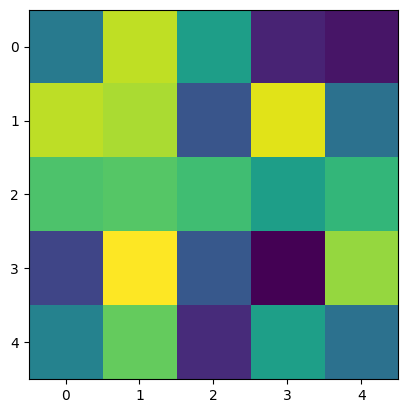

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data = np.random.rand(5, 5)  # Должен быть 2D или 3D массив
plt.imshow(data)

In [4]:
import pickle
import numpy as np
# from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
# %matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
import PIL
print(PIL.__version__)

10.4.0


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 18 11:55:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 55%   35C    P8             22W /  170W |     374MiB /  12288MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
import warnings

In [9]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [50]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        # x = np.array(x / 255, dtype='float32')
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset/testset')

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [16]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

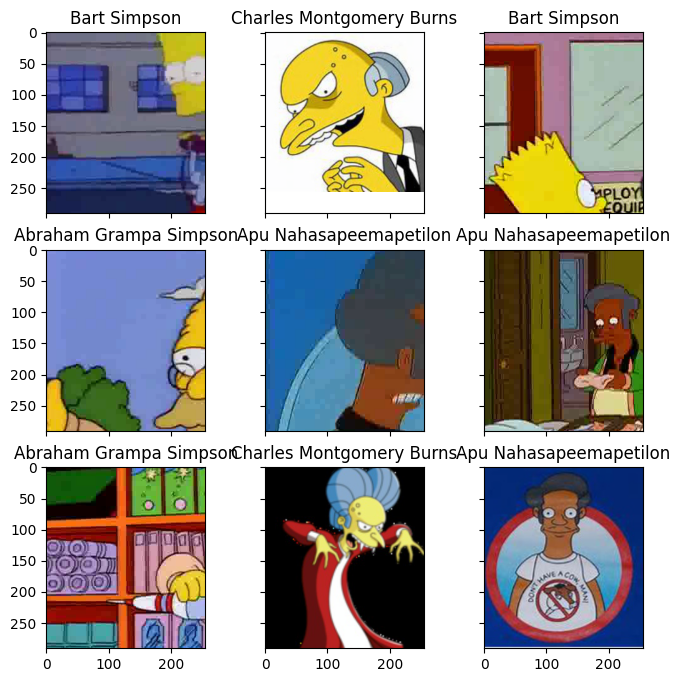

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [207]:
from torch.nn import functional as F

# Очень простая сеть
class MyCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(2048, 64)
        self.fc2 = nn.Linear(64, 64)

        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = F.softmax(self.out(x), dim=1)
        return logits

In [187]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

        # === тут выводим точность по батчу ===
        batch_acc = (preds == labels).float().mean().item()
        print(f"Batch accuracy: {batch_acc:.4f}")

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [56]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [202]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [99]:
!pip install torchinfo

In [118]:
im_val.shape

torch.Size([3, 224, 224])

In [208]:
from torchinfo import summary

# допустим, твоя модель:
simple_cnn = MyCnn(n_classes).to(DEVICE)
random_characters = int(np.random.uniform(0,1000))
im_val, label = val_dataset[random_characters]
im_val = im_val.unsqueeze(0).to(DEVICE)
# im_val = torch.tensor(im_val, dtype=torch.float).to(DEVICE).item()
x = simple_cnn.forward(im_val)

# например, для входного размера (batch_size=64, 3, 224, 224)
summary(simple_cnn, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MyCnn                                    [64, 42]                  --
├─Sequential: 1-1                        [64, 16, 110, 110]        --
│    └─Conv2d: 2-1                       [64, 16, 221, 221]        784
│    └─BatchNorm2d: 2-2                  [64, 16, 221, 221]        32
│    └─ReLU: 2-3                         [64, 16, 221, 221]        --
│    └─MaxPool2d: 2-4                    [64, 16, 110, 110]        --
├─Sequential: 1-2                        [64, 16, 54, 54]          --
│    └─Conv2d: 2-5                       [64, 16, 108, 108]        2,320
│    └─BatchNorm2d: 2-6                  [64, 16, 108, 108]        32
│    └─ReLU: 2-7                         [64, 16, 108, 108]        --
│    └─MaxPool2d: 2-8                    [64, 16, 54, 54]          --
├─Sequential: 1-3                        [64, 16, 26, 26]          --
│    └─Conv2d: 2-9                       [64, 16, 52, 52]          2,320
│    └─B

In [209]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = MyCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

Запустим обучение сети.

In [59]:
val_dataset

In [210]:
# if val_dataset is None:
val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [51]:
# train_dataset = SimpsonsDataset(train_files, mode='train')
#
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# for inputs, labels in train_loader:
#     print(inputs, labels)
#     break

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
          [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
          [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

In [232]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch accuracy: 0.5078
Batch accuracy: 0.5391
Batch accuracy: 0.6016
Batch accuracy: 0.5312
Batch accuracy: 0.4531
Batch accuracy: 0.4922
Batch accuracy: 0.5391
Batch accuracy: 0.5703
Batch accuracy: 0.4766
Batch accuracy: 0.5469
Batch accuracy: 0.5156
Batch accuracy: 0.5156
Batch accuracy: 0.4062
Batch accuracy: 0.4688
Batch accuracy: 0.4766
Batch accuracy: 0.5156
Batch accuracy: 0.5234
Batch accuracy: 0.5000
Batch accuracy: 0.4844
Batch accuracy: 0.4922
Batch accuracy: 0.5156
Batch accuracy: 0.4844
Batch accuracy: 0.5000
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.5234
Batch accuracy: 0.4766
Batch accuracy: 0.4766
Batch accuracy: 0.4219
Batch accuracy: 0.5391
Batch accuracy: 0.5312
Batch accuracy: 0.6328
Batch accuracy: 0.4531
Batch accuracy: 0.5391
Batch accuracy: 0.5781
Batch accuracy: 0.5469
Batch accuracy: 0.4922
Batch accuracy: 0.5547
Batch accuracy: 0.5391
Batch accuracy: 0.4531
Batch accuracy: 0.3984
Batch accuracy: 0.5391
Batch accuracy: 0.5000
Batch accur

epoch:   7%|▋         | 1/15 [01:24<19:47, 84.85s/it]


Epoch 001 train_loss: 3.2526     val_loss 3.2543 train_acc 0.5259 val_acc 0.5241
Batch accuracy: 0.5469
Batch accuracy: 0.6094
Batch accuracy: 0.5781
Batch accuracy: 0.6797
Batch accuracy: 0.5859
Batch accuracy: 0.6016
Batch accuracy: 0.4688
Batch accuracy: 0.5703
Batch accuracy: 0.4609
Batch accuracy: 0.5703
Batch accuracy: 0.5703
Batch accuracy: 0.5781
Batch accuracy: 0.5469
Batch accuracy: 0.4844
Batch accuracy: 0.6328
Batch accuracy: 0.5156
Batch accuracy: 0.5703
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.5391
Batch accuracy: 0.6016
Batch accuracy: 0.5859
Batch accuracy: 0.4531
Batch accuracy: 0.5156
Batch accuracy: 0.4453
Batch accuracy: 0.5078
Batch accuracy: 0.5156
Batch accuracy: 0.5312
Batch accuracy: 0.4766
Batch accuracy: 0.5547
Batch accuracy: 0.4531
Batch accuracy: 0.4609
Batch accuracy: 0.5703
Batch accuracy: 0.4922
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.5391
Batch accuracy: 0.5312
Batch accuracy: 0.5156
Batch accuracy: 0.484

epoch:  13%|█▎        | 2/15 [02:49<18:18, 84.53s/it]


Epoch 002 train_loss: 3.2454     val_loss 3.2565 train_acc 0.5330 val_acc 0.5220
Batch accuracy: 0.5625
Batch accuracy: 0.5469
Batch accuracy: 0.5234
Batch accuracy: 0.5469
Batch accuracy: 0.5391
Batch accuracy: 0.5469
Batch accuracy: 0.5547
Batch accuracy: 0.5938
Batch accuracy: 0.5703
Batch accuracy: 0.6016
Batch accuracy: 0.5000
Batch accuracy: 0.4844
Batch accuracy: 0.5078
Batch accuracy: 0.5234
Batch accuracy: 0.4922
Batch accuracy: 0.5000
Batch accuracy: 0.5000
Batch accuracy: 0.4688
Batch accuracy: 0.5938
Batch accuracy: 0.5781
Batch accuracy: 0.5469
Batch accuracy: 0.5156
Batch accuracy: 0.5703
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.6250
Batch accuracy: 0.5625
Batch accuracy: 0.5703
Batch accuracy: 0.5234
Batch accuracy: 0.5078
Batch accuracy: 0.5391
Batch accuracy: 0.5625
Batch accuracy: 0.5156
Batch accuracy: 0.5547
Batch accuracy: 0.5859
Batch accuracy: 0.5781
Batch accuracy: 0.5859
Batch accuracy: 0.5391
Batch accuracy: 0.5391
Batch accuracy: 0.562

epoch:  20%|██        | 3/15 [04:13<16:52, 84.36s/it]


Epoch 003 train_loss: 3.2393     val_loss 3.2537 train_acc 0.5393 val_acc 0.5243
Batch accuracy: 0.5938
Batch accuracy: 0.5703
Batch accuracy: 0.4531
Batch accuracy: 0.5469
Batch accuracy: 0.5078
Batch accuracy: 0.6797
Batch accuracy: 0.5625
Batch accuracy: 0.4844
Batch accuracy: 0.6172
Batch accuracy: 0.5703
Batch accuracy: 0.4141
Batch accuracy: 0.5469
Batch accuracy: 0.4453
Batch accuracy: 0.5781
Batch accuracy: 0.5781
Batch accuracy: 0.5625
Batch accuracy: 0.5156
Batch accuracy: 0.4844
Batch accuracy: 0.6094
Batch accuracy: 0.5781
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.6328
Batch accuracy: 0.6016
Batch accuracy: 0.6172
Batch accuracy: 0.4375
Batch accuracy: 0.5078
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.7031
Batch accuracy: 0.5234
Batch accuracy: 0.6016
Batch accuracy: 0.5703
Batch accuracy: 0.5469
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.5547
Batch accuracy: 0.5938
Batch accuracy: 0.6094
Batch accuracy: 0.507

epoch:  27%|██▋       | 4/15 [05:37<15:27, 84.32s/it]


Epoch 004 train_loss: 3.2338     val_loss 3.2555 train_acc 0.5447 val_acc 0.5225
Batch accuracy: 0.5703
Batch accuracy: 0.6172
Batch accuracy: 0.5391
Batch accuracy: 0.6484
Batch accuracy: 0.6016
Batch accuracy: 0.5312
Batch accuracy: 0.5781
Batch accuracy: 0.5156
Batch accuracy: 0.4922
Batch accuracy: 0.5547
Batch accuracy: 0.5859
Batch accuracy: 0.6250
Batch accuracy: 0.5781
Batch accuracy: 0.4531
Batch accuracy: 0.5469
Batch accuracy: 0.5469
Batch accuracy: 0.5547
Batch accuracy: 0.5234
Batch accuracy: 0.5156
Batch accuracy: 0.5859
Batch accuracy: 0.5000
Batch accuracy: 0.5938
Batch accuracy: 0.5703
Batch accuracy: 0.5625
Batch accuracy: 0.5469
Batch accuracy: 0.5859
Batch accuracy: 0.5859
Batch accuracy: 0.6016
Batch accuracy: 0.4844
Batch accuracy: 0.5781
Batch accuracy: 0.5312
Batch accuracy: 0.5156
Batch accuracy: 0.5078
Batch accuracy: 0.6094
Batch accuracy: 0.5859
Batch accuracy: 0.5156
Batch accuracy: 0.5781
Batch accuracy: 0.5625
Batch accuracy: 0.5938
Batch accuracy: 0.460

epoch:  33%|███▎      | 5/15 [07:01<14:03, 84.35s/it]


Epoch 005 train_loss: 3.2340     val_loss 3.2653 train_acc 0.5443 val_acc 0.5134
Batch accuracy: 0.5234
Batch accuracy: 0.5391
Batch accuracy: 0.5312
Batch accuracy: 0.4922
Batch accuracy: 0.5156
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.5234
Batch accuracy: 0.5859
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.5859
Batch accuracy: 0.5469
Batch accuracy: 0.5938
Batch accuracy: 0.5781
Batch accuracy: 0.5000
Batch accuracy: 0.5547
Batch accuracy: 0.6562
Batch accuracy: 0.5938
Batch accuracy: 0.5625
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.6250
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.5312
Batch accuracy: 0.5938
Batch accuracy: 0.5703
Batch accuracy: 0.5703
Batch accuracy: 0.5391
Batch accuracy: 0.5000
Batch accuracy: 0.5625
Batch accuracy: 0.5156
Batch accuracy: 0.6250
Batch accuracy: 0.6094
Batch accuracy: 0.5391
Batch accuracy: 0.507

epoch:  40%|████      | 6/15 [08:26<12:38, 84.28s/it]


Epoch 006 train_loss: 3.2332     val_loss 3.2884 train_acc 0.5451 val_acc 0.4901
Batch accuracy: 0.5156
Batch accuracy: 0.5938
Batch accuracy: 0.4609
Batch accuracy: 0.4922
Batch accuracy: 0.5781
Batch accuracy: 0.5312
Batch accuracy: 0.5703
Batch accuracy: 0.5078
Batch accuracy: 0.5938
Batch accuracy: 0.5469
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.5000
Batch accuracy: 0.6250
Batch accuracy: 0.5547
Batch accuracy: 0.6172
Batch accuracy: 0.6328
Batch accuracy: 0.6250
Batch accuracy: 0.5078
Batch accuracy: 0.5234
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.5469
Batch accuracy: 0.5078
Batch accuracy: 0.5156
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.5859
Batch accuracy: 0.6016
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.5078
Batch accuracy: 0.5312
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.5469
Batch accuracy: 0.5391
Batch accuracy: 0.546

epoch:  47%|████▋     | 7/15 [09:50<11:13, 84.15s/it]


Epoch 007 train_loss: 3.2363     val_loss 3.2688 train_acc 0.5413 val_acc 0.5078
Batch accuracy: 0.4609
Batch accuracy: 0.5859
Batch accuracy: 0.5781
Batch accuracy: 0.5078
Batch accuracy: 0.5156
Batch accuracy: 0.4609
Batch accuracy: 0.5703
Batch accuracy: 0.5625
Batch accuracy: 0.5078
Batch accuracy: 0.5000
Batch accuracy: 0.5312
Batch accuracy: 0.5703
Batch accuracy: 0.5078
Batch accuracy: 0.5703
Batch accuracy: 0.5156
Batch accuracy: 0.5547
Batch accuracy: 0.5391
Batch accuracy: 0.5312
Batch accuracy: 0.4531
Batch accuracy: 0.5703
Batch accuracy: 0.4609
Batch accuracy: 0.5078
Batch accuracy: 0.5469
Batch accuracy: 0.4844
Batch accuracy: 0.6406
Batch accuracy: 0.5078
Batch accuracy: 0.5469
Batch accuracy: 0.6250
Batch accuracy: 0.6406
Batch accuracy: 0.5000
Batch accuracy: 0.4766
Batch accuracy: 0.6094
Batch accuracy: 0.5469
Batch accuracy: 0.5312
Batch accuracy: 0.5547
Batch accuracy: 0.5547
Batch accuracy: 0.5234
Batch accuracy: 0.5547
Batch accuracy: 0.5469
Batch accuracy: 0.562

epoch:  53%|█████▎    | 8/15 [11:14<09:49, 84.27s/it]


Epoch 008 train_loss: 3.2307     val_loss 3.2633 train_acc 0.5472 val_acc 0.5143
Batch accuracy: 0.5156
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.6641
Batch accuracy: 0.5547
Batch accuracy: 0.5000
Batch accuracy: 0.5078
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5078
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.5312
Batch accuracy: 0.6562
Batch accuracy: 0.4922
Batch accuracy: 0.5391
Batch accuracy: 0.5859
Batch accuracy: 0.5312
Batch accuracy: 0.4688
Batch accuracy: 0.5781
Batch accuracy: 0.5391
Batch accuracy: 0.5625
Batch accuracy: 0.5781
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5234
Batch accuracy: 0.4766
Batch accuracy: 0.5234
Batch accuracy: 0.5625
Batch accuracy: 0.6250
Batch accuracy: 0.5078
Batch accuracy: 0.5859
Batch accuracy: 0.6641
Batch accuracy: 0.5703
Batch accuracy: 0.5234
Batch accuracy: 0.6484
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.5781
Batch accuracy: 0.562

epoch:  60%|██████    | 9/15 [12:38<08:24, 84.12s/it]


Epoch 009 train_loss: 3.2250     val_loss 3.2491 train_acc 0.5530 val_acc 0.5283
Batch accuracy: 0.5234
Batch accuracy: 0.4297
Batch accuracy: 0.5234
Batch accuracy: 0.6562
Batch accuracy: 0.5000
Batch accuracy: 0.5312
Batch accuracy: 0.5156
Batch accuracy: 0.5703
Batch accuracy: 0.6328
Batch accuracy: 0.5156
Batch accuracy: 0.5938
Batch accuracy: 0.6094
Batch accuracy: 0.5234
Batch accuracy: 0.5625
Batch accuracy: 0.6016
Batch accuracy: 0.5781
Batch accuracy: 0.6016
Batch accuracy: 0.5859
Batch accuracy: 0.5703
Batch accuracy: 0.5781
Batch accuracy: 0.6016
Batch accuracy: 0.4297
Batch accuracy: 0.4844
Batch accuracy: 0.4766
Batch accuracy: 0.5312
Batch accuracy: 0.5625
Batch accuracy: 0.6094
Batch accuracy: 0.6094
Batch accuracy: 0.5703
Batch accuracy: 0.5312
Batch accuracy: 0.6172
Batch accuracy: 0.6016
Batch accuracy: 0.5312
Batch accuracy: 0.5625
Batch accuracy: 0.5547
Batch accuracy: 0.5703
Batch accuracy: 0.6016
Batch accuracy: 0.5781
Batch accuracy: 0.6016
Batch accuracy: 0.625

epoch:  67%|██████▋   | 10/15 [14:02<07:00, 84.02s/it]


Epoch 010 train_loss: 3.2186     val_loss 3.2469 train_acc 0.5594 val_acc 0.5306
Batch accuracy: 0.5469
Batch accuracy: 0.5938
Batch accuracy: 0.5781
Batch accuracy: 0.5859
Batch accuracy: 0.5625
Batch accuracy: 0.5078
Batch accuracy: 0.6016
Batch accuracy: 0.5312
Batch accuracy: 0.5703
Batch accuracy: 0.5469
Batch accuracy: 0.5469
Batch accuracy: 0.4922
Batch accuracy: 0.6094
Batch accuracy: 0.6328
Batch accuracy: 0.5391
Batch accuracy: 0.5391
Batch accuracy: 0.5234
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.4688
Batch accuracy: 0.6406
Batch accuracy: 0.5234
Batch accuracy: 0.5234
Batch accuracy: 0.5391
Batch accuracy: 0.5938
Batch accuracy: 0.5625
Batch accuracy: 0.5469
Batch accuracy: 0.6250
Batch accuracy: 0.5938
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.4453
Batch accuracy: 0.5703
Batch accuracy: 0.5547
Batch accuracy: 0.5938
Batch accuracy: 0.5078
Batch accuracy: 0.5391
Batch accuracy: 0.5781
Batch accuracy: 0.5859
Batch accuracy: 0.578

epoch:  73%|███████▎  | 11/15 [15:26<05:36, 84.11s/it]


Epoch 011 train_loss: 3.2217     val_loss 3.2703 train_acc 0.5562 val_acc 0.5061
Batch accuracy: 0.5625
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.5469
Batch accuracy: 0.5625
Batch accuracy: 0.5000
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.6016
Batch accuracy: 0.5938
Batch accuracy: 0.5234
Batch accuracy: 0.5547
Batch accuracy: 0.5312
Batch accuracy: 0.5469
Batch accuracy: 0.5703
Batch accuracy: 0.5312
Batch accuracy: 0.6016
Batch accuracy: 0.6094
Batch accuracy: 0.5547
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.6719
Batch accuracy: 0.6562
Batch accuracy: 0.5938
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.6172
Batch accuracy: 0.5703
Batch accuracy: 0.5547
Batch accuracy: 0.5391
Batch accuracy: 0.4609
Batch accuracy: 0.5156
Batch accuracy: 0.5234
Batch accuracy: 0.5469
Batch accuracy: 0.6016
Batch accuracy: 0.5781
Batch accuracy: 0.5234
Batch accuracy: 0.5625
Batch accuracy: 0.5547
Batch accuracy: 0.515

epoch:  80%|████████  | 12/15 [16:50<04:12, 84.14s/it]


Epoch 012 train_loss: 3.2181     val_loss 3.2385 train_acc 0.5597 val_acc 0.5397
Batch accuracy: 0.6016
Batch accuracy: 0.4844
Batch accuracy: 0.6328
Batch accuracy: 0.5312
Batch accuracy: 0.5703
Batch accuracy: 0.5234
Batch accuracy: 0.5469
Batch accuracy: 0.6094
Batch accuracy: 0.5625
Batch accuracy: 0.5859
Batch accuracy: 0.4453
Batch accuracy: 0.5547
Batch accuracy: 0.5234
Batch accuracy: 0.5703
Batch accuracy: 0.5938
Batch accuracy: 0.6328
Batch accuracy: 0.5938
Batch accuracy: 0.5781
Batch accuracy: 0.5625
Batch accuracy: 0.5547
Batch accuracy: 0.6016
Batch accuracy: 0.5234
Batch accuracy: 0.5703
Batch accuracy: 0.5391
Batch accuracy: 0.5156
Batch accuracy: 0.5938
Batch accuracy: 0.5625
Batch accuracy: 0.5469
Batch accuracy: 0.5625
Batch accuracy: 0.4844
Batch accuracy: 0.5234
Batch accuracy: 0.6172
Batch accuracy: 0.6016
Batch accuracy: 0.5000
Batch accuracy: 0.5703
Batch accuracy: 0.6094
Batch accuracy: 0.5625
Batch accuracy: 0.5391
Batch accuracy: 0.5469
Batch accuracy: 0.523

epoch:  87%|████████▋ | 13/15 [18:15<02:48, 84.26s/it]


Epoch 013 train_loss: 3.2186     val_loss 3.2420 train_acc 0.5593 val_acc 0.5359
Batch accuracy: 0.5391
Batch accuracy: 0.5000
Batch accuracy: 0.5469
Batch accuracy: 0.5859
Batch accuracy: 0.5078
Batch accuracy: 0.5156
Batch accuracy: 0.5469
Batch accuracy: 0.5703
Batch accuracy: 0.5703
Batch accuracy: 0.5547
Batch accuracy: 0.5469
Batch accuracy: 0.5078
Batch accuracy: 0.5469
Batch accuracy: 0.5938
Batch accuracy: 0.5781
Batch accuracy: 0.5938
Batch accuracy: 0.6250
Batch accuracy: 0.5781
Batch accuracy: 0.5859
Batch accuracy: 0.5547
Batch accuracy: 0.5391
Batch accuracy: 0.5391
Batch accuracy: 0.5234
Batch accuracy: 0.5312
Batch accuracy: 0.5234
Batch accuracy: 0.5781
Batch accuracy: 0.5312
Batch accuracy: 0.6094
Batch accuracy: 0.5234
Batch accuracy: 0.6172
Batch accuracy: 0.5078
Batch accuracy: 0.5234
Batch accuracy: 0.5625
Batch accuracy: 0.5859
Batch accuracy: 0.6719
Batch accuracy: 0.5859
Batch accuracy: 0.6484
Batch accuracy: 0.5625
Batch accuracy: 0.5312
Batch accuracy: 0.664

epoch:  93%|█████████▎| 14/15 [19:39<01:24, 84.27s/it]


Epoch 014 train_loss: 3.2172     val_loss 3.2414 train_acc 0.5604 val_acc 0.5361
Batch accuracy: 0.5391
Batch accuracy: 0.5469
Batch accuracy: 0.5391
Batch accuracy: 0.5547
Batch accuracy: 0.6250
Batch accuracy: 0.5469
Batch accuracy: 0.5625
Batch accuracy: 0.6172
Batch accuracy: 0.5781
Batch accuracy: 0.5391
Batch accuracy: 0.5234
Batch accuracy: 0.5234
Batch accuracy: 0.6406
Batch accuracy: 0.5234
Batch accuracy: 0.6719
Batch accuracy: 0.5234
Batch accuracy: 0.6016
Batch accuracy: 0.5234
Batch accuracy: 0.5234
Batch accuracy: 0.5391
Batch accuracy: 0.5703
Batch accuracy: 0.5703
Batch accuracy: 0.4844
Batch accuracy: 0.5703
Batch accuracy: 0.5625
Batch accuracy: 0.6328
Batch accuracy: 0.6250
Batch accuracy: 0.5156
Batch accuracy: 0.5156
Batch accuracy: 0.6484
Batch accuracy: 0.5469
Batch accuracy: 0.5469
Batch accuracy: 0.5781
Batch accuracy: 0.5469
Batch accuracy: 0.5547
Batch accuracy: 0.6797
Batch accuracy: 0.6016
Batch accuracy: 0.5469
Batch accuracy: 0.5703
Batch accuracy: 0.609

epoch: 100%|██████████| 15/15 [21:03<00:00, 84.25s/it]


Epoch 015 train_loss: 3.2105     val_loss 3.2438 train_acc 0.5675 val_acc 0.5334


Построим кривые обучения

In [233]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = list(val_acc)
val_acc = [x.cpu().numpy() for x in val_acc]

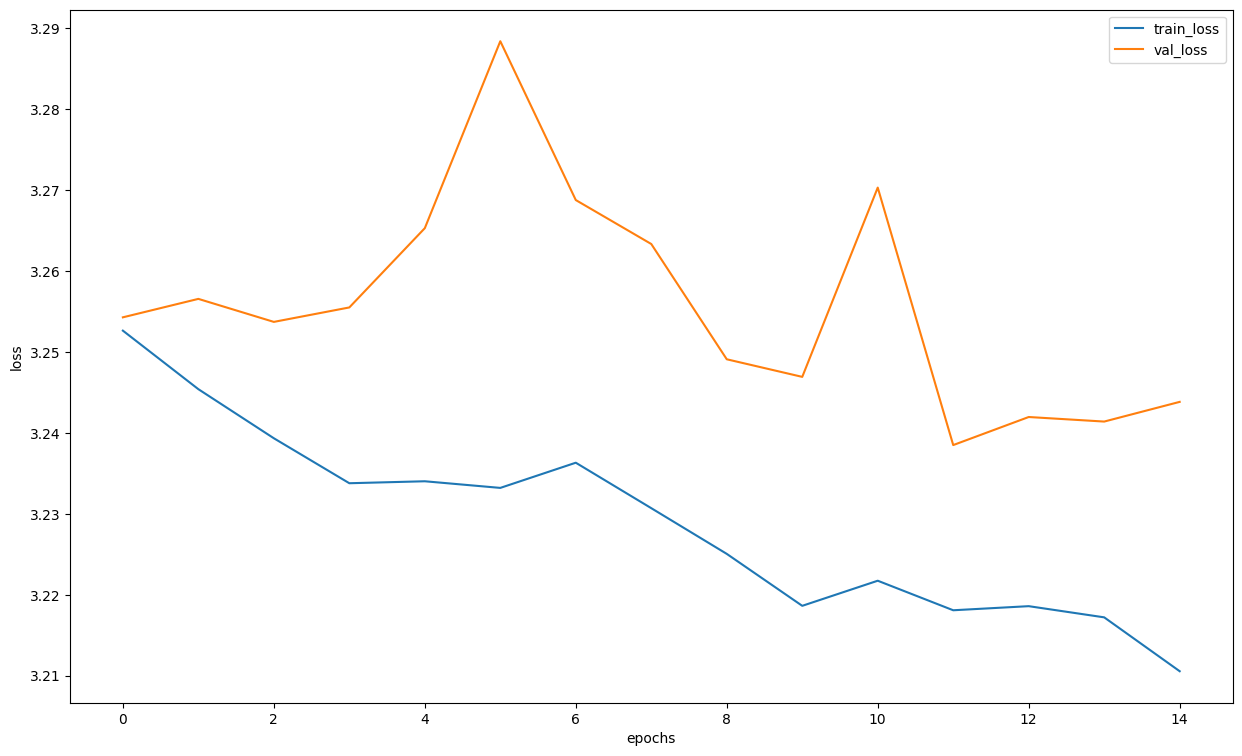

In [234]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

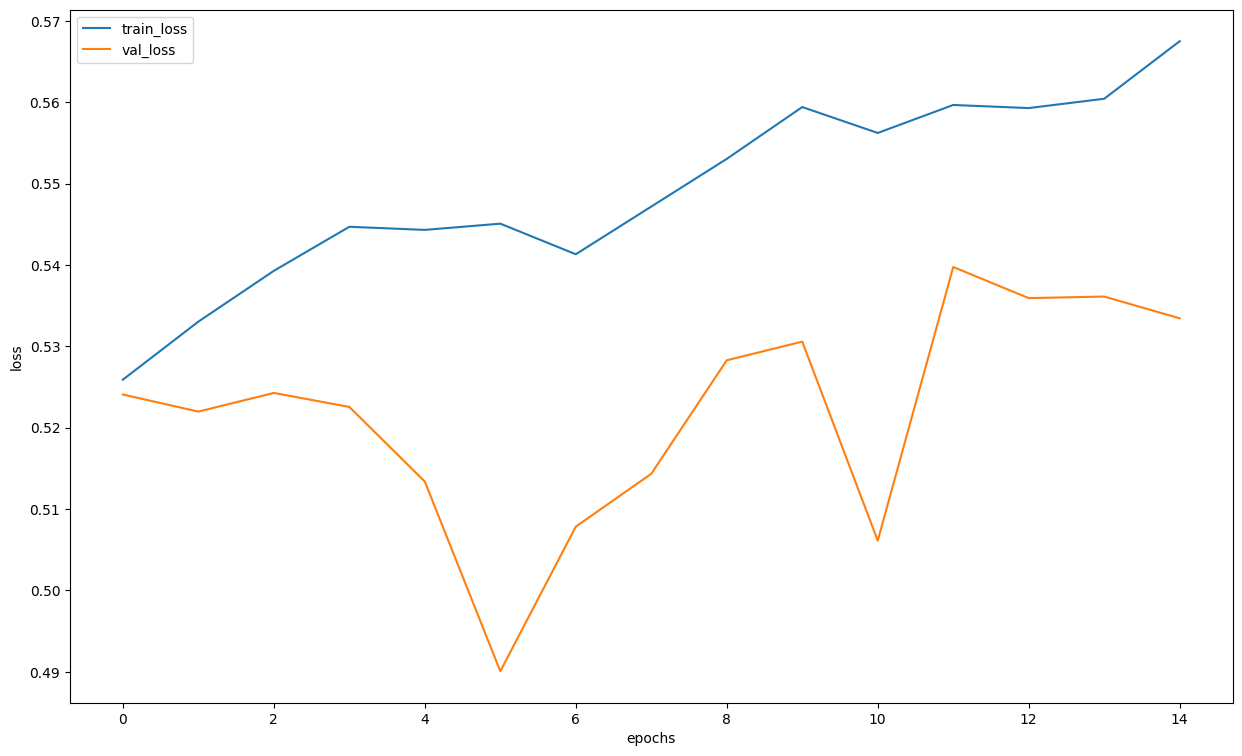

In [235]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_loss")
plt.plot(val_acc, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [64]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [159]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [170]:
idxs = list(map(int, np.random.uniform(0,1000, 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [171]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [172]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [173]:
print(actual_labels, y_pred)

[6, 2, 6, 6, 4, 4, 6, 2, 4, 4, 2, 4, 2, 6, 6, 0, 4, 5, 4, 0, 4, 0, 6, 4, 6, 4, 4, 5, 4, 4, 4, 4, 2, 2, 0, 0, 6, 2, 6, 6, 0, 6, 2, 4, 4, 0, 0, 0, 6, 2, 3, 0, 4, 2, 2, 4, 2, 4, 4, 4, 0, 2, 3, 6, 4, 2, 0, 4, 0, 2, 6, 2, 6, 4, 0, 4, 5, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 6, 0, 4, 2, 2, 0, 4, 4, 4, 3, 6, 4, 4, 6, 0, 0, 6, 6, 4, 6, 3, 2, 0, 4, 0, 4, 0, 6, 1, 6, 2, 6, 4, 2, 4, 6, 4, 0, 2, 6, 6, 2, 2, 4, 6, 2, 6, 4, 6, 4, 2, 0, 0, 4, 0, 4, 6, 6, 0, 4, 0, 4, 2, 4, 4, 4, 6, 4, 4, 2, 6, 4, 6, 0, 4, 6, 0, 6, 2, 6, 0, 4, 4, 4, 2, 0, 6, 4, 4, 3, 6, 4, 6, 0, 4, 6, 4, 4, 6, 4, 6, 4, 0, 6, 6, 6, 1, 0, 6, 0, 6, 0, 4, 6, 2, 4, 4, 4, 6, 2, 0, 0, 4, 0, 6, 0, 6, 2, 4, 6, 6, 0, 4, 6, 2, 0, 6, 4, 6, 4, 6, 4, 4, 0, 6, 4, 0, 0, 4, 4, 4, 5, 0, 2, 6, 0, 3, 2, 6, 0, 4, 4, 0, 2, 6, 3, 6, 0, 4, 0, 4, 4, 4, 4, 0, 6, 6, 6, 0, 2, 2, 2, 0, 6, 3, 2, 6, 5, 4, 4, 6, 0, 0, 2, 4, 6, 6, 5, 0, 6, 0, 4, 5, 6, 3, 3, 4, 1, 0, 6, 5, 5, 6, 5, 2, 2, 4, 4, 0, 4, 6, 4, 6, 6, 6, 0, 0, 0, 0, 6, 4, 4, 2, 4, 6, 4, 2, 4, 4, 2, 

In [174]:
from sklearn.metrics import f1_score, classification_report
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)
print(classification_report(actual_labels, y_pred))

F1-оценка: 0.379
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       231
           1       0.00      0.00      0.00        12
           2       0.84      0.85      0.84       156
           3       0.00      0.00      0.00        29
           4       0.77      0.74      0.75       335
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00       214
           7       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0
          37       0.00      0.00      0.00         0

    accuracy                           0.38      1000
   macro avg       0.12      0.11      0.11      1000
weighted avg       0.39      0.38      0.38      1000



C:\Users\normist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\normist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\normist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\normist\anaconda3\Lib\site-packag

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

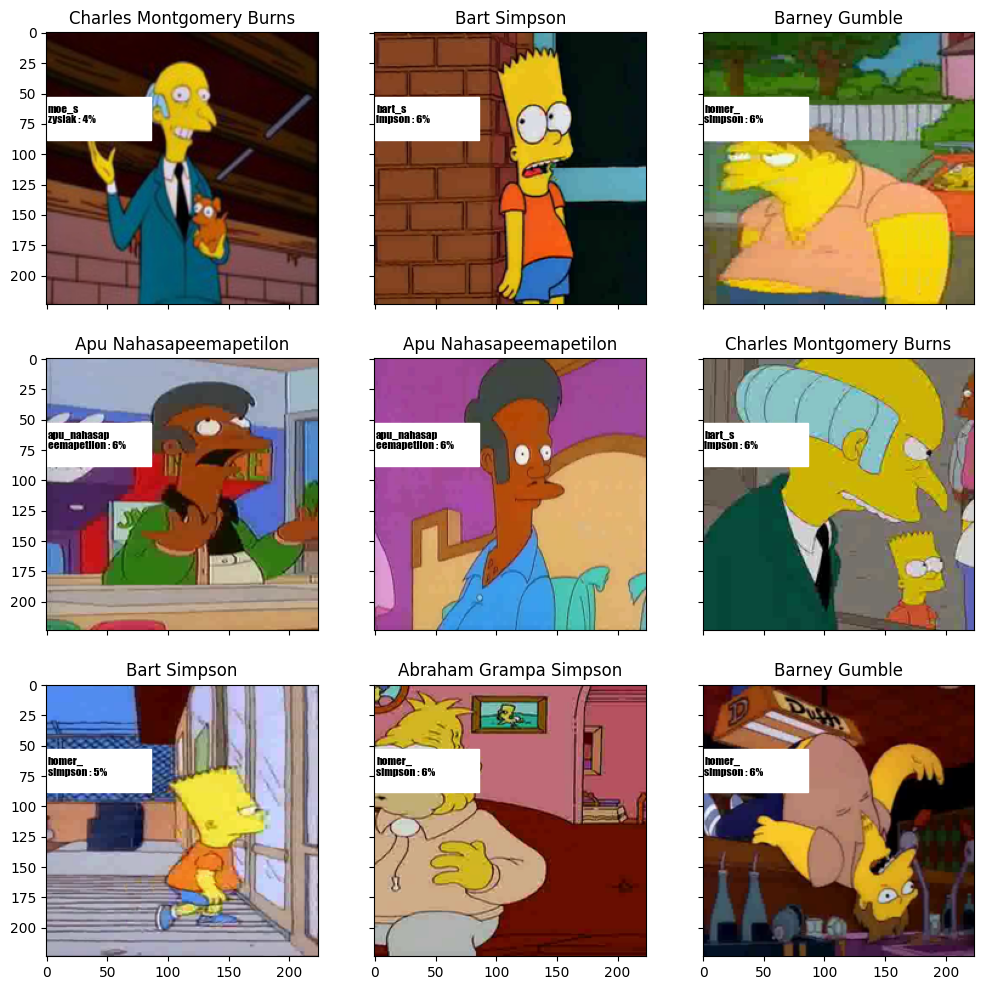

In [176]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [81]:
test_filenames

['img0.jpg',
 'img1.jpg',
 'img10.jpg',
 'img100.jpg',
 'img101.jpg',
 'img102.jpg',
 'img103.jpg',
 'img104.jpg',
 'img105.jpg',
 'img106.jpg',
 'img107.jpg',
 'img108.jpg',
 'img109.jpg',
 'img11.jpg',
 'img110.jpg',
 'img111.jpg',
 'img112.jpg',
 'img113.jpg',
 'img114.jpg',
 'img115.jpg',
 'img116.jpg',
 'img117.jpg',
 'img118.jpg',
 'img119.jpg',
 'img12.jpg',
 'img120.jpg',
 'img121.jpg',
 'img122.jpg',
 'img123.jpg',
 'img124.jpg',
 'img125.jpg',
 'img126.jpg',
 'img127.jpg',
 'img128.jpg',
 'img129.jpg',
 'img13.jpg',
 'img130.jpg',
 'img131.jpg',
 'img132.jpg',
 'img133.jpg',
 'img134.jpg',
 'img135.jpg',
 'img136.jpg',
 'img137.jpg',
 'img138.jpg',
 'img139.jpg',
 'img14.jpg',
 'img140.jpg',
 'img141.jpg',
 'img142.jpg',
 'img143.jpg',
 'img144.jpg',
 'img145.jpg',
 'img146.jpg',
 'img147.jpg',
 'img148.jpg',
 'img149.jpg',
 'img15.jpg',
 'img150.jpg',
 'img151.jpg',
 'img152.jpg',
 'img153.jpg',
 'img154.jpg',
 'img155.jpg',
 'img156.jpg',
 'img157.jpg',
 'img158.jpg',
 'img

In [82]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [83]:
import pandas as pd
# my_submit = pd.read_csv("data/sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [86]:
my_submit.to_csv('submits/simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
